In [36]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from array import array
import math
from termcolor import colored as cl
import requests

In [33]:
#df = pd.DataFrame(pd.read_csv(r"C:\Users\Lenovo\Downloads\wipro_stock_data.csv"))

In [34]:
#df.head()

In [35]:
# data = pd.DataFrame(columns = ['PrevC','open','close','high','low'])
# data['open'] = df['Open Price']
# data['PrevC'] = df['Prev Close']
# data['high'] = df['High Price']
# data['low'] = df['Low Price']
# data['close'] = df['Close Price']
# data.index = df['Date']

In [5]:
# data.head()

,PrevC,open,close,high,low
Date,,,,,
10-Jul-2019,265.50,264.7,266.95,269.50,263.30
11-Jul-2019,266.95,267.5,267.75,270.00,266.10
12-Jul-2019,267.75,268.0,258.95,268.65,258.05
15-Jul-2019,258.95,260.0,259.90,262.00,255.90
16-Jul-2019,259.90,259.0,260.00,262.70,256.25


In [37]:
def get_historical_data(symbol, start_date = None):
    api_key = ("6b2431e5c9msh3720b51e161f965p194d46jsn8880777cb29e")
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

googl = get_historical_data('GOOGL', '2020-01-01')
googl

,open,high,low,close,adj close,volume
2020-01-02,1348.41,1368.6800,1346.4900,1368.68,1368.68,1364265.0
2020-01-03,1348.00,1373.7500,1347.3200,1361.52,1361.52,1170629.0
2020-01-06,1351.63,1398.3200,1351.0000,1397.81,1397.81,2339343.0
2020-01-07,1400.46,1403.5000,1391.5600,1395.11,1395.11,1726456.0
2020-01-08,1394.82,1411.8500,1392.6300,1405.04,1405.04,1766274.0
...,...,...,...,...,...,...
2021-07-16,2553.26,2556.2300,2523.0700,2539.40,2539.40,1021227.0
2021-07-19,2521.79,2524.1000,2470.1000,2491.56,2491.56,1398379.0
2021-07-20,2510.55,2540.8636,2487.0100,2524.19,2524.19,1315822.0
2021-07-21,2522.67,2551.9200,2520.4700,2550.98,2550.98,1037309.0


In [6]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

wipro_macd = get_macd(data['close'], 26, 12, 9)
wipro_macd.tail()

,macd,signal,hist
Date,,,
02-Jul-2021,4.464261,8.044804,-3.580543
05-Jul-2021,3.459105,7.127664,-3.668559
06-Jul-2021,2.333024,6.168736,-3.835713
07-Jul-2021,1.388282,5.212645,-3.824364
08-Jul-2021,0.540541,4.278224,-3.737684


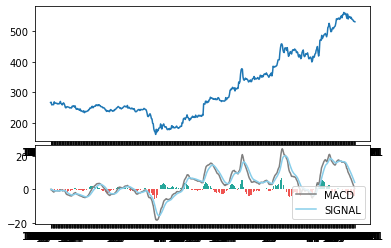

In [7]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(data['close'], wipro_macd['macd'], wipro_macd['signal'], wipro_macd['hist'])

In [8]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(data['close'], wipro_macd)

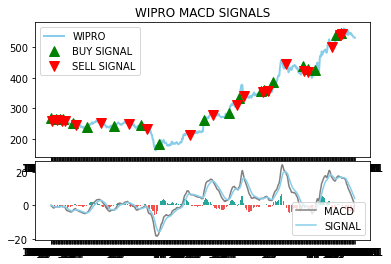

In [9]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(data['close'], color = 'skyblue', linewidth = 2, label = 'WIPRO')
ax1.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(data.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('WIPRO MACD SIGNALS')
ax2.plot(wipro_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(wipro_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(wipro_macd)):
    if str(wipro_macd['hist'][i])[0] == '-':
        ax2.bar(wipro_macd.index[i], wipro_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(wipro_macd.index[i], wipro_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

In [10]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(data['close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = wipro_macd['macd']
signal = wipro_macd['signal']
close_price = data['close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(data.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(data.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,macd,signal,macd_signal,macd_position
Date,,,,,
10-Jul-2019,266.95,0.000000,0.000000,0,1
11-Jul-2019,267.75,0.063818,0.012764,1,1
12-Jul-2019,258.95,-0.588904,-0.107570,-1,0
15-Jul-2019,259.90,-1.017802,-0.289616,0,0
16-Jul-2019,260.00,-1.334256,-0.498544,0,0
...,...,...,...,...,...
02-Jul-2021,538.60,4.464261,8.044804,0,0
05-Jul-2021,536.35,3.459105,7.127664,0,0
06-Jul-2021,532.60,2.333024,6.168736,0,0


In [11]:
wipro_ret = pd.DataFrame(np.diff(data['close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(wipro_ret)):
    try:
        returns = wipro_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/data['close'][-1])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing $100k in GOOGL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing $100k in GOOGL : 28670.0
Profit percentage of the MACD strategy : 28%


In [14]:
def get_benchmark(start_date, investment_value):
    spy = get_historical_data('SPY', start_date)['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('MACD Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))


IEXAuthenticationError: The IEX Cloud API key must be provided either through the token variable or through the environmental variable IEX_TOKEN.

In [ ]:
############### Bollinger Bands

In [23]:
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

data['sma_20'] = sma(data['close'], 20)
data.tail()

,PrevC,open,close,high,low,sma_20,upper_bb,lower_bb
Date,,,,,,,,
02-Jul-2021,539.35,540.10,538.60,542.30,533.60,549.1925,562.906583,535.478417
05-Jul-2021,538.60,542.90,536.35,542.90,535.55,548.5975,563.467621,533.727379
06-Jul-2021,536.35,536.55,532.60,538.30,531.85,547.6975,564.151790,531.243210
07-Jul-2021,532.60,534.05,532.15,536.40,525.10,547.0950,564.914354,529.275646
08-Jul-2021,532.15,533.90,531.00,536.95,528.00,545.9325,564.789811,527.075189


In [24]:
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

data['upper_bb'], data['lower_bb'] = bb(data['close'], data['sma_20'], 20)
data.tail()

,PrevC,open,close,high,low,sma_20,upper_bb,lower_bb
Date,,,,,,,,
02-Jul-2021,539.35,540.10,538.60,542.30,533.60,549.1925,562.906583,535.478417
05-Jul-2021,538.60,542.90,536.35,542.90,535.55,548.5975,563.467621,533.727379
06-Jul-2021,536.35,536.55,532.60,538.30,531.85,547.6975,564.151790,531.243210
07-Jul-2021,532.60,534.05,532.15,536.40,525.10,547.0950,564.914354,529.275646
08-Jul-2021,532.15,533.90,531.00,536.95,528.00,545.9325,564.789811,527.075189


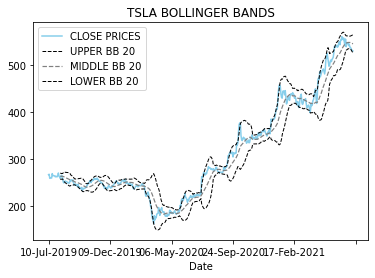

In [25]:
data['close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
data['upper_bb'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
data['sma_20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
data['lower_bb'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc = 'upper left')
plt.title('TSLA BOLLINGER BANDS')
plt.show()

In [26]:
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = implement_bb_strategy(data['close'], data['lower_bb'], data['upper_bb'])


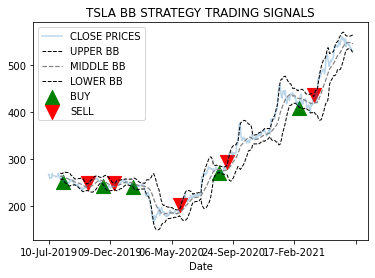

In [27]:
data['close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
data['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
data['sma_20'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
data['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(data.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(data.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('TSLA BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

In [28]:
position = []
for i in range(len(bb_signal)):
    if bb_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(data['close'])):
    if bb_signal[i] == 1:
        position[i] = 1
    elif bb_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
upper_bb = data['upper_bb']
lower_bb = data['lower_bb']
close_price = data['close']
bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(data.index)
position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(data.index)

frames = [close_price, upper_bb, lower_bb, bb_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index().drop('Date', axis = 1)

strategy

,close,upper_bb,lower_bb,bb_signal,bb_position
0,266.95,NaN,NaN,0,1
1,267.75,NaN,NaN,0,1
2,258.95,NaN,NaN,0,1
3,259.90,NaN,NaN,0,1
4,260.00,NaN,NaN,0,1
...,...,...,...,...,...
491,538.60,562.906583,535.478417,0,0
492,536.35,563.467621,533.727379,0,0
493,532.60,564.151790,531.243210,0,0
494,532.15,564.914354,529.275646,0,0


In [29]:
wipro_ret = pd.DataFrame(np.diff(data['close'])).rename(columns = {0:'returns'})
bb_strategy_ret = []

for i in range(len(wipro_ret)):
    try:
        returns = wipro_ret['returns'][i]*strategy['bb_position'][i]
        bb_strategy_ret.append(returns)
    except:
        pass
    
bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/data['close'][-1])
bb_investment_ret = []

for i in range(len(bb_strategy_ret_df['bb_returns'])):
    returns = number_of_stocks*bb_strategy_ret_df['bb_returns'][i]
    bb_investment_ret.append(returns)

bb_investment_ret_df = pd.DataFrame(bb_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(bb_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the BB strategy by investing $100k in TSLA : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the BB strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the BB strategy by investing $100k in TSLA : -235.0
Profit percentage of the BB strategy : -1%
